In [103]:
import json
import numpy as np
import pandas as pd
import scipy.sparse
import pickle as pkl
from collections import defaultdict
import networkx as nx
from matplotlib import pyplot as plt
import scipy.io
import operator

First we are loading the ingredients and recipes dataframes

In [104]:
dataFramesFile = open('data/dataframes.pkl', 'rb')
dataFrames = pkl.load(dataFramesFile)
ingredients_df = dataFrames['ingredients']
# recipes_df = dataFrames['recipes']

In [105]:
ingredients_df.head(5)


,name
0,yogurt
1,strawberries
2,cereals ready-to-eat
3,sugars granulated
4,sugars powdered


Then we are loading the ingredients graph and do some initial exploration

ingredientsGraph[ *ingredientA* ][ *ingredientB* ] = number of times ingredients are encountered together

In [106]:
ingredientsGraphFile = open('data/ingredient_graph.pkl', 'rb')
ingredientsGraphRaw = pkl.load(ingredientsGraphFile)
ingredientsGraph = nx.from_numpy_matrix(ingredientsGraphRaw)
ingredientsGraphRaw = ingredientsGraphRaw.flatten()

In [107]:
print('Number of nodes: {}, Number of edges: {}'. format(ingredientsGraph.number_of_nodes(), ingredientsGraph.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(ingredientsGraph.number_of_selfloops(), nx.number_connected_components(ingredientsGraph)))

Number of nodes: 251, Number of edges: 15996
Number of self-loops: 0, Number of connected components: 1


(array([14., 27., 35., 32., 34., 37., 34., 22., 16.]),
 array([  8.        ,  34.66666667,  61.33333333,  88.        ,
        114.66666667, 141.33333333, 168.        , 194.66666667,
        221.33333333, 248.        ]),
 <a list of 9 Patch objects>)

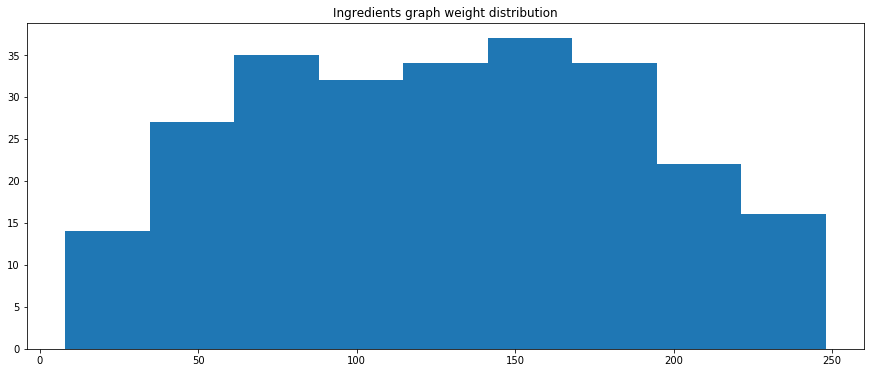

In [108]:
fig, axis = plt.subplots(1, 1, figsize=(15,6))
axis.set_title('Ingredients graph weight distribution')
ingredientsGraph_degrees = [ingredientsGraph.degree(node) for node in ingredientsGraph.nodes()]
axis.hist(ingredientsGraph_degrees, bins = 9)

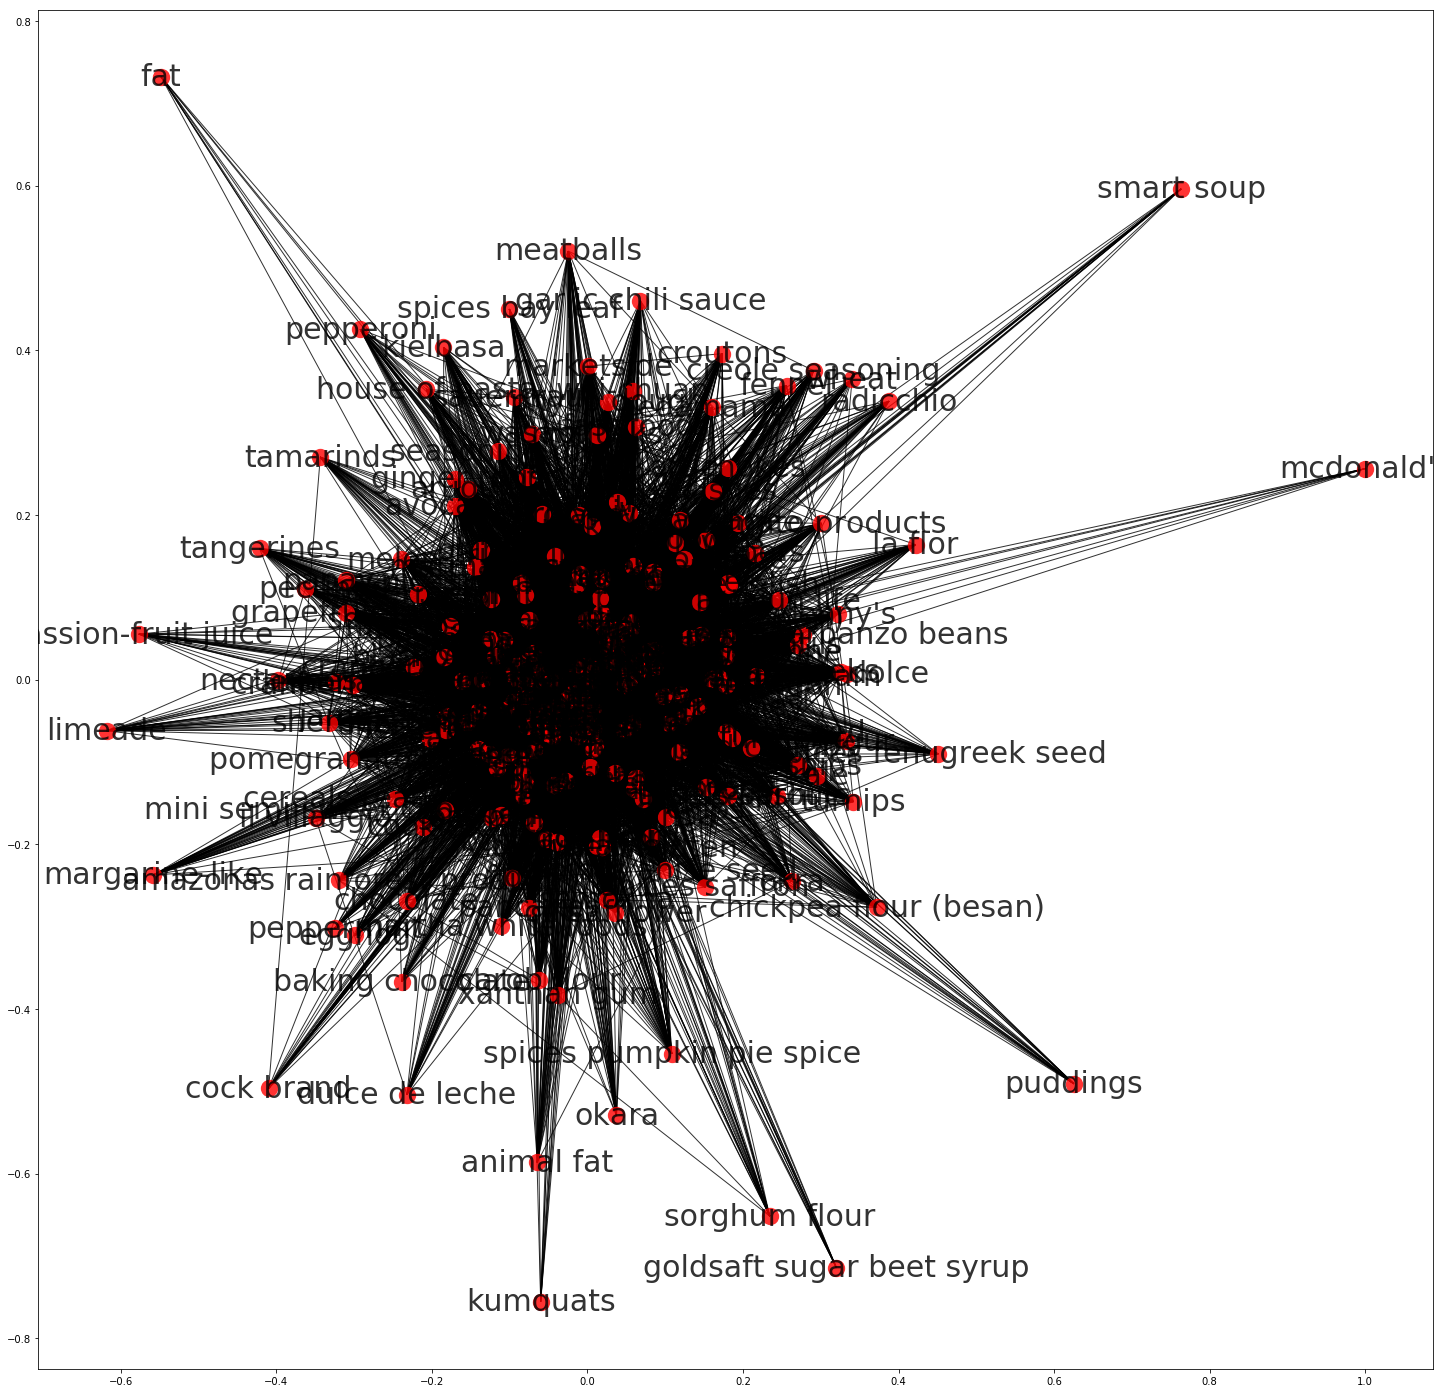

In [109]:
fig, axis = plt.subplots(1, 1, figsize=(25, 25))
nx.draw_networkx(ingredientsGraph, ax = axis, labels = ingredients_df.to_dict()['name'], node_size = 300, font_size = 30, alpha = 0.8, linewidths = 0.01)

Going to take only the ingredients with weight >= 800, the most common one

In [110]:
ingredientsGraphRawTop = ingredientsGraphRaw.copy()
ingredientsGraphRawTop[ ingredientsGraphRawTop < 800 ] = 0

ingredientsGraphTopWeight = nx.from_numpy_matrix(ingredientsGraphRawTop.reshape((251, 251)))
allNodes = set(ingredientsGraphTopWeight.nodes)
nodesToRemove = set(list(nx.isolates(ingredientsGraphTopWeight)))
nodesLeft = allNodes.difference(nodesToRemove)
# ingredientsGraphTopWeight.remove_nodes_from(nodesToRemove)

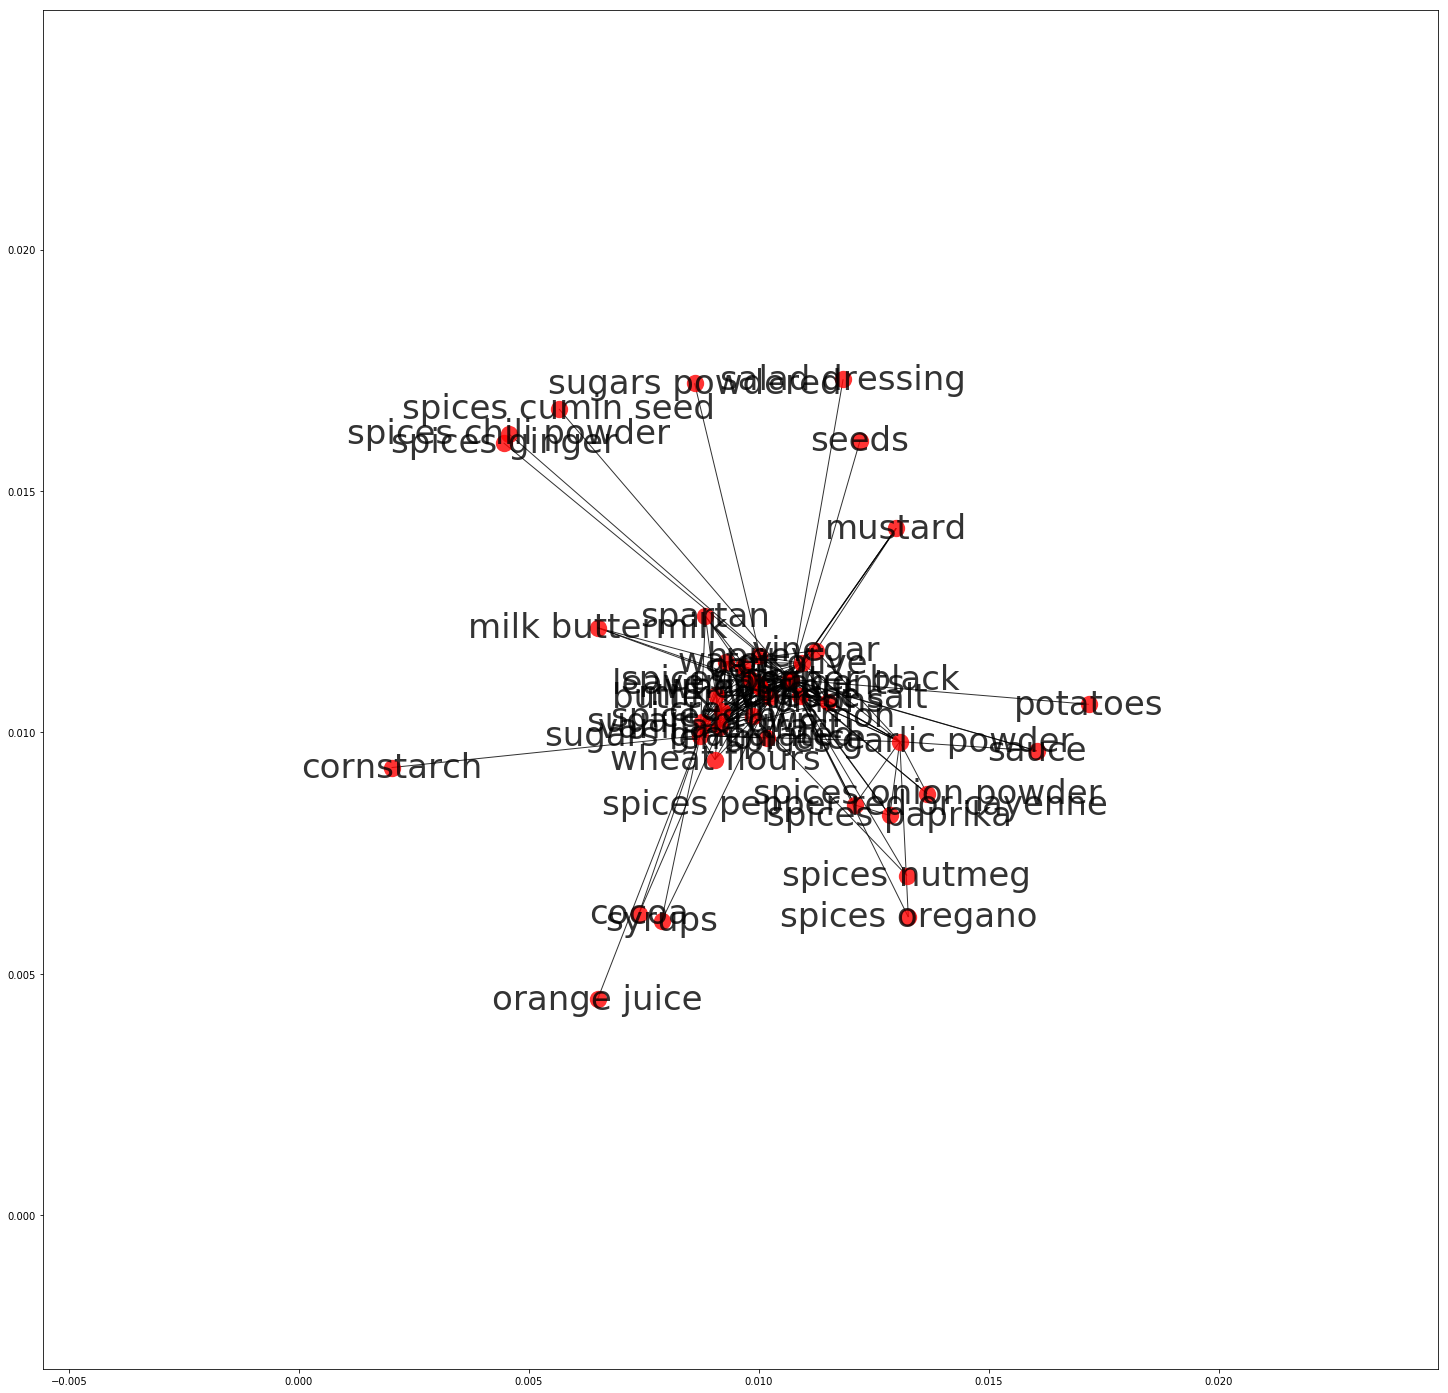

In [111]:
fig, axis = plt.subplots(1, 1, figsize=(25, 25))
nx.draw_networkx(ingredientsGraphTopWeight, ax = axis, nodelist = nodesLeft, labels = ingredients_df.to_dict()['name'], node_size = 300, font_size = 34, alpha = 0.8, linewidths = 0.01)

In [112]:
print('Filtered graph -> Number of nodes: {}, Number of edges: {}'. format(ingredientsGraphTopWeight.number_of_nodes(), ingredientsGraphTopWeight.number_of_edges()))
print('Filtered graph ->Number of self-loops: {}, Number of connected components: {}'. format(ingredientsGraphTopWeight.number_of_selfloops(), nx.number_connected_components(ingredientsGraphTopWeight)))

Filtered graph -> Number of nodes: 251, Number of edges: 167
Filtered graph ->Number of self-loops: 0, Number of connected components: 210


### Computing the Degree Centrality

In [113]:
degree_centrality = nx.degree_centrality(ingredientsGraph)
ingredientsCentrality = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse = True)

ingredientsIdToVal = ingredients_df.to_dict()['name']
for ingredient in ingredientsCentrality[:10]:
    print(f"{ingredientsIdToVal[ingredient[0]]} has centrality {ingredient[1]}")
    

water has centrality 0.992
salt has centrality 0.98
sugars granulated has centrality 0.9520000000000001
butter without salt has centrality 0.9520000000000001
oil olive has centrality 0.9440000000000001
milk fluid has centrality 0.9400000000000001
nuts has centrality 0.9400000000000001
wheat flour has centrality 0.936
cheese has centrality 0.932
honey has centrality 0.928


### Computing the Closeness Centrality

In [114]:
closeness_centrality = nx.closeness_centrality(ingredientsGraph)
ingredientsClCentrality = sorted(closeness_centrality.items(), key=operator.itemgetter(1), reverse = True)

for ingredient in ingredientsClCentrality[:10]:
    print(f"{ingredientsIdToVal[ingredient[0]]} has centrality {ingredient[1]}")
    

water has centrality 0.9920634920634921
salt has centrality 0.9803921568627451
sugars granulated has centrality 0.9541984732824428
butter without salt has centrality 0.9541984732824428
oil olive has centrality 0.946969696969697
milk fluid has centrality 0.9433962264150944
nuts has centrality 0.9433962264150944
wheat flour has centrality 0.9398496240601504
cheese has centrality 0.9363295880149812
honey has centrality 0.9328358208955224


### Computing the Betweenes
So, if were to remove an ingredient that would affect the most number of recipes,
water would have the most impact, closely followed by salt, butter and sugars

In [115]:
betweenness_centrality = nx.betweenness_centrality(ingredientsGraph)
ingredientsBtCentrality = sorted(betweenness_centrality.items(), key=operator.itemgetter(1), reverse = True)

for ingredient in ingredientsBtCentrality[:10]:
    print(f"{ingredient[0]}: {ingredientsIdToVal[ingredient[0]]} has centrality {ingredient[1]}")
    

70: water has centrality 0.015189097415118324
16: salt has centrality 0.013444051306579581
47: butter without salt has centrality 0.010934546726877862
3: sugars granulated has centrality 0.010733613572896648
14: wheat flour has centrality 0.010602036834054737
63: milk fluid has centrality 0.010028771751129525
62: cheese has centrality 0.009738015664399302
7: oil olive has centrality 0.009656086066861873
75: nuts has centrality 0.009633718636149698
50: honey has centrality 0.009494549552925328


One way to compute the distances from one node to all the other nodes is to create a tree using Breadth-First-search. Breadth-First search will eliminate any cycles and leave us with the shortest paths to each node

Below we created a tree starting with the most important ingredient: Water

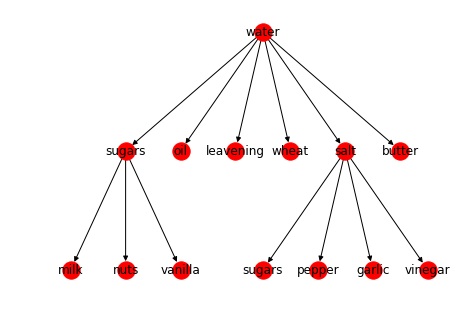

In [116]:
ingredientsGraphRawTop = ingredientsGraphRaw.copy()
ingredientsGraphRawTop[ ingredientsGraphRawTop < 2400 ] = 0

ingredientsGraphTopWeight = nx.from_numpy_matrix(ingredientsGraphRawTop.reshape((251, 251)))
tree = nx.bfs_tree(ingredientsGraphTopWeight, 70)
positions = nx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")

allLabels = ingredients_df.to_dict()['name']
filteredLabels = {}
for node in list(tree.nodes):
    crtLabel = allLabels[node].split(' ')
    if crtLabel[0] == 'spices':
        filteredLabels[node] = crtLabel[1]
    else:
        filteredLabels[node] = crtLabel[0]
filteredLabels
        
nx.draw(tree, positions, labels = filteredLabels, with_labels = True)

### Now we are going to remove the most used ingredients

In [117]:
ingredientsGraphRawLow = ingredientsGraphRaw.copy()
ingredientsGraphRawLow[ ingredientsGraphRawLow > 200 ] = 0
ingredientsGraphBottomWeight = nx.from_numpy_matrix(ingredientsGraphRawLow.reshape((251, 251)))
print('Graph Low Weights -> Number of nodes: {}, Number of edges: {}'. format(ingredientsGraphBottomWeight.number_of_nodes(), ingredientsGraphBottomWeight.number_of_edges()))
print('Graph Low Weights ->Number of self-loops: {}, Number of connected components: {}'. format(ingredientsGraphBottomWeight.number_of_selfloops(), nx.number_connected_components(ingredientsGraphBottomWeight)))

Graph Low Weights -> Number of nodes: 251, Number of edges: 15157
Graph Low Weights ->Number of self-loops: 0, Number of connected components: 1


In [118]:
betweenness_centrality = nx.degree_centrality(ingredientsGraphBottomWeight)
ingredientsDgCentrality = sorted(betweenness_centrality.items(), key=operator.itemgetter(1), reverse = True)

for ingredient in ingredientsDgCentrality[:10]:
    print(f"{ingredient[0]}: {ingredientsIdToVal[ingredient[0]]} has centrality {ingredient[1]}")


62: cheese has centrality 0.808
51: rice has centrality 0.8
0: yogurt has centrality 0.792
12: orange juice has centrality 0.792
50: honey has centrality 0.788
136: vinegar has centrality 0.788
94: corn has centrality 0.784
29: spices ginger has centrality 0.78
59: lemon juice has centrality 0.78
63: milk fluid has centrality 0.776
